In [ ]:
!pip install ta

In [ ]:
import yfinance as yf
import pandas as pd
import ta
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# nvidia data

nvidia = yf.download('NVDA', start='2023-01-01', end='2023-12-31', interval="1d")
nvidia = nvidia.dropna()

close = nvidia["Close"].squeeze()
high = nvidia["High"].squeeze()
low = nvidia["Low"].squeeze()
volume = nvidia["Volume"].squeeze()

obv = ta.volume.OnBalanceVolumeIndicator(close=close, volume=volume)
nvidia["OBV"] = obv.on_balance_volume()

ad = ta.volume.AccDistIndexIndicator(high=high, low=low, close=close, volume=volume)
nvidia["AD"] = ad.acc_dist_index()

adx = ta.trend.ADXIndicator(high=high, low=low, close=close, window=14)
nvidia["ADX"] = adx.adx()

macd = ta.trend.MACD(close=close)
nvidia["MACD"] = macd.macd()
nvidia["MACD_Signal"] = macd.macd_signal()
nvidia["MACD_Diff"] = macd.macd_diff()

rsi = ta.momentum.RSIIndicator(close=close, window=14)
nvidia["RSI"] = rsi.rsi()

stoch = ta.momentum.StochasticOscillator(high=high, low=low, close=close, window=14, smooth_window=3)
nvidia["Stoch_K"] = stoch.stoch()
nvidia["Stoch_D"] = stoch.stoch_signal()

nvidia = nvidia.replace([np.inf, -np.inf], np.nan)
nvidia = nvidia.dropna()

print(nvidia.head())

[*********************100%***********************]  1 of 1 completed

Price                      Adj Close      Close       High        Low  \
Ticker                          NVDA       NVDA       NVDA       NVDA   
Date                                                                    
2023-02-21 00:00:00+00:00  20.641411  20.655001  21.493999  20.618000   
2023-02-22 00:00:00+00:00  20.740345  20.754000  21.104000  20.421000   
2023-02-23 00:00:00+00:00  23.648430  23.664000  23.888000  23.025000   
2023-02-24 00:00:00+00:00  23.270678  23.285999  23.474001  22.947001   
2023-02-27 00:00:00+00:00  23.485537  23.500999  23.879999  23.454000   

Price                           Open      Volume         OBV            AD  \
Ticker                          NVDA        NVDA                             
Date                                                                         
2023-02-21 00:00:00+00:00  21.000000   410015000  6896309000  4.304132e+09   
2023-02-22 00:00:00+00:00  20.707001   513184000  7409493000  4.291358e+09   
2023-02-23 00:00:00+00:00

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/di

                               SARIMAX Results                                
Dep. Variable:                   NVDA   No. Observations:                  173
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 -94.358
Date:                Fri, 22 Nov 2024   AIC                            208.716
Time:                        19:51:05   BIC                            240.191
Sample:                             0   HQIC                           221.486
                                - 173                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Open_NVDA      -0.7030   7.01e-19     -1e+18      0.000      -0.703      -0.703
High_NVDA       0.7575    7.7e-19   9.84e+17      0.000       0.757       0.757
Low_NVDA        0.7833   5.61e-19    1.4e+18    

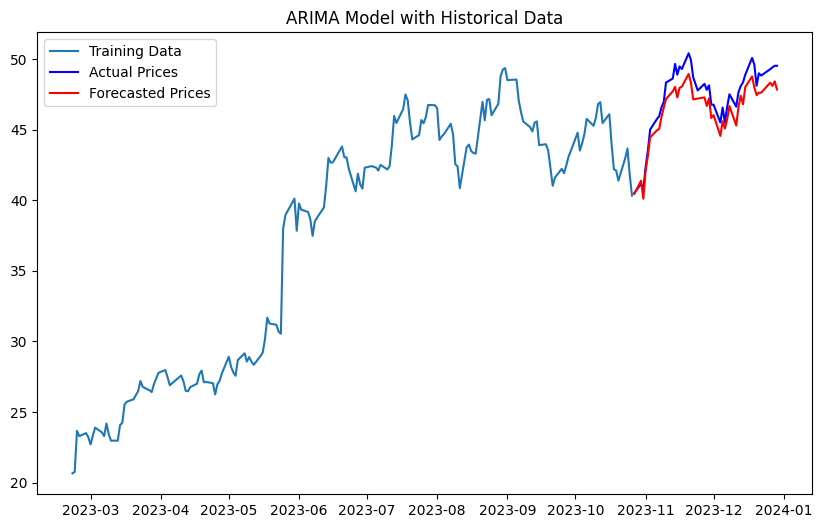

In [ ]:
# use this data for

close_prices = nvidia['Close']

train_size = int(len(close_prices) * 0.8)

train = close_prices[:train_size]
test = close_prices[train_size:]

exog_train = nvidia[['Open', 'High', 'Low', 'Volume']].iloc[:train_size]
exog_test = nvidia[['Open', 'High', 'Low', 'Volume']].iloc[train_size:]

model = ARIMA(train, order=(5, 1, 0), exog=exog_train)
model_fit = model.fit()

print(model_fit.summary())

forecast = model_fit.forecast(steps=len(test), exog=exog_test)

plt.figure(figsize=(10, 6))
plt.plot(train, label='Training Data')
plt.plot(test.index, test, label='Actual Prices', color='blue')
plt.plot(test.index, forecast, label='Forecasted Prices', color='red')
plt.legend()
plt.title('ARIMA Model with Historical Data')
plt.show()

Historical data and market sentiment

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                   NVDA   No. Observations:                  173
Model:                 ARIMA(5, 1, 0)   Log Likelihood                  -2.738
Date:                Fri, 22 Nov 2024   AIC                             43.476
Time:                        19:51:13   BIC                            103.278
Sample:                             0   HQIC                            67.739
                                - 173                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Open_NVDA      -0.1898   3.95e-19   -4.8e+17      0.000      -0.190      -0.190
High_NVDA       0.3310   4.64e-19   7.13e+17      0.000       0.331       0.331
Low_NVDA        0.2540   2.68e-19   9.49e+17    

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


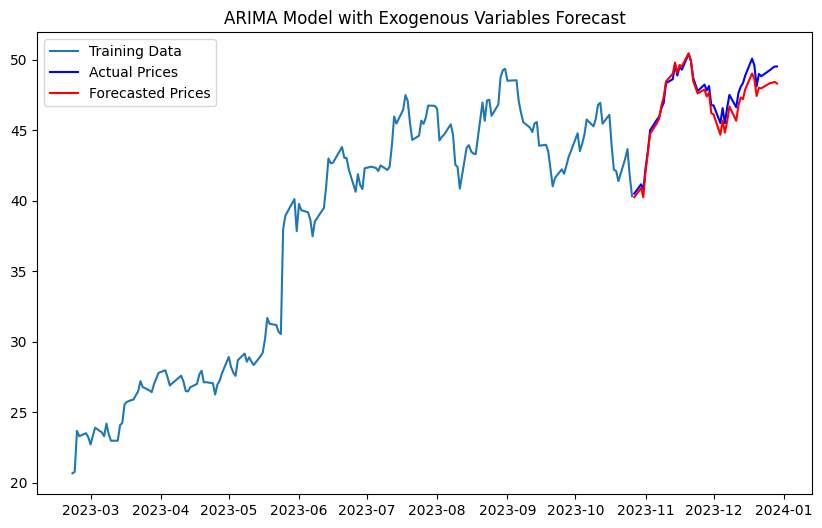

In [ ]:
# Preparing data for training and testing
close_prices = nvidia['Close']
train_size = int(len(close_prices) * 0.8)
train = close_prices[:train_size]
test = close_prices[train_size:]

# Including all technical indicators as exogenous variables
exog_vars = nvidia[['Open', 'High', 'Low', 'Volume', 'OBV', 'AD', 'ADX', 'MACD', 'MACD_Signal', 'MACD_Diff', 'RSI', 'Stoch_K', 'Stoch_D']]
exog_train = exog_vars.iloc[:train_size]
exog_test = exog_vars.iloc[train_size:]

# ARIMA model with exogenous variables
model = ARIMA(train, order=(5, 1, 0), exog=exog_train)
model_fit = model.fit()

print(model_fit.summary())

# Forecasting
forecast = model_fit.forecast(steps=len(test), exog=exog_test)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(train, label='Training Data')
plt.plot(test.index, test, label='Actual Prices', color='blue')
plt.plot(test.index, forecast, label='Forecasted Prices', color='red')
plt.legend()
plt.title('ARIMA Model with Exogenous Variables Forecast')
plt.show()


LSTM with historical data only

In [ ]:
# Download historical stock data for NVDA
nvda_data = yf.download('NVDA', start='2010-01-01', end='2024-11-16')

# Use 'Close' prices for prediction
data = nvda_data[['Close', 'High', 'Low', 'Volume']]

# Normalize the data using MinMaxScaler (scales data between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define function to create sequences of data
def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])  # Use past 'time_step' days as features
        y.append(data[i, 0])  # Predict the 'Close' price of the next day
    return np.array(X), np.array(y)

# Create sequences for the data
time_step = 60  # Use the past 60 days to predict the next day's price
X, y = create_sequences(scaled_data, time_step)

# Split the data into training and testing sets (80/20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for LSTM (LSTM expects 3D input: [samples, time steps, features])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the LSTM model
model = Sequential()

# Add the LSTM layer (units can be tuned)
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout for regularization
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer (predict next day's 'Close' price)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform the predictions and true values to get actual price
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model performance
mae = mean_absolute_error(y_test_actual, y_pred_actual)
mse = mean_squared_error(y_test_actual, y_pred_actual)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(nvda_data.index[train_size + time_step:], y_test_actual, label='Actual Prices', color='blue')
plt.plot(nvda_data.index[train_size + time_step:], y_pred_actual, label='Predicted Prices (LSTM)', color='red')
plt.legend()
plt.title('LSTM Predictions vs Actual Prices')
plt.show()

[*********************100%***********************]  1 of 1 completed

Epoch 1/10



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 4.6634e-04
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 3.1987e-05
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 3.8652e-05
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 2.5046e-05
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 3.2523e-05
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 3.3126e-05
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 2.4897e-05
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 2.8861e-05
Epoch 9/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 1.9495e-05
Epoch 10/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 3.0164e-05
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


ValueError: non-broadcastable output operand with shape (737,1) doesn't match the broadcast shape (737,4)

LSTM with historical data and market sentiment data

In [ ]:
# Use 'Close' prices and technical indicators for prediction
data = nvda_data[['Close', 'OBV', 'AD', 'ADX', 'MACD', 'MACD_Signal', 'MACD_Diff', 'RSI', 'Stoch_K', 'Stoch_D']]

# Normalize the data using MinMaxScaler (scales data between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define function to create sequences of data
def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i])  # Use past 'time_step' days as features
        y.append(data[i, 0])  # Predict the 'Close' price of the next day
    return np.array(X), np.array(y)

# Create sequences for the data
time_step = 60  # Use the past 60 days to predict the next day's price
X, y = create_sequences(scaled_data, time_step)

# Split the data into training and testing sets (80/20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for LSTM (LSTM expects 3D input: [samples, time steps, features])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Define the LSTM model
model = Sequential()

# Add the LSTM layer (units can be tuned)
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Dropout for regularization
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer (predict next day's 'Close' price)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform the predictions and true values to get actual price
y_pred_actual = scaler.inverse_transform(np.hstack((y_pred, np.zeros((y_pred.shape[0], scaled_data.shape[1]-1)))))
y_test_actual = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1]-1)))))

# Evaluate the model performance
mae = mean_absolute_error(y_test_actual[:, 0], y_pred_actual[:, 0])
mse = mean_squared_error(y_test_actual[:, 0], y_pred_actual[:, 0])
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(nvda_data.index[train_size + time_step:], y_test_actual[:, 0], label='Actual Prices', color='blue')
plt.plot(nvda_data.index[train_size + time_step:], y_pred_actual[:, 0], label='Predicted Prices (LSTM)', color='red')
plt.legend()
plt.title('LSTM Predictions vs Actual Prices')
plt.show()
